In [94]:
import os
import logging
import random
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet152, ResNet152_Weights
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from dataclasses import dataclass
from torch.cuda.amp import GradScaler, autocast

import warnings
warnings.filterwarnings('ignore')

# Configuration des logs
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


@dataclass
class TrainingConfiguration:
    """Configuration for the training process."""
    data_dir: str = './movement_database'
    batch_size: int = 32
    learning_rate: float = 0.001
    weight_decay: float = 1e-4
    max_epochs: int = 150
    patience: int = 5
    train_split: float = 0.8
    use_amp: bool = True  # Utilisation de la formation en précision mixte
    num_workers: int = 4  # Nombre de workers pour les DataLoader
    multi_gpu: bool = True  # Utilisation de plusieurs GPU

In [60]:
training_config = TrainingConfiguration()

In [61]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def plot_original_sample_images(data_dir, num_images=9, save_path=None):
    """
    Plots a sample of original images from the dataset in a 4x4 grid and optionally saves the plot.

    Args:
        data_dir (str): Path to the root directory of the dataset.
        num_images (int, optional): Number of images to display. Defaults to 16.
        save_path (str, optional): Path to save the plot as a PNG file. If None, the plot is not saved. Defaults to None.
    """
    # Get all class folders
    class_folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    axes = axes.flatten()

    for i in range(num_images):
        # Randomly select a class folder
        class_folder = random.choice(class_folders)
        class_path = os.path.join(data_dir, class_folder)
        
        # Randomly select an image from the class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_file = random.choice(image_files)
        image_path = os.path.join(class_path, image_file)
        
        # Open and display the image
        with Image.open(image_path) as img:
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(class_folder, fontsize=10)

    plt.tight_layout()

    # Save the plot if a save path is provided
    if save_path:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

# Example usage:
# plot_original_sample_images('./movement_database', save_path='./img/sample_images.png')

Plot saved to ./img/sample_images.png


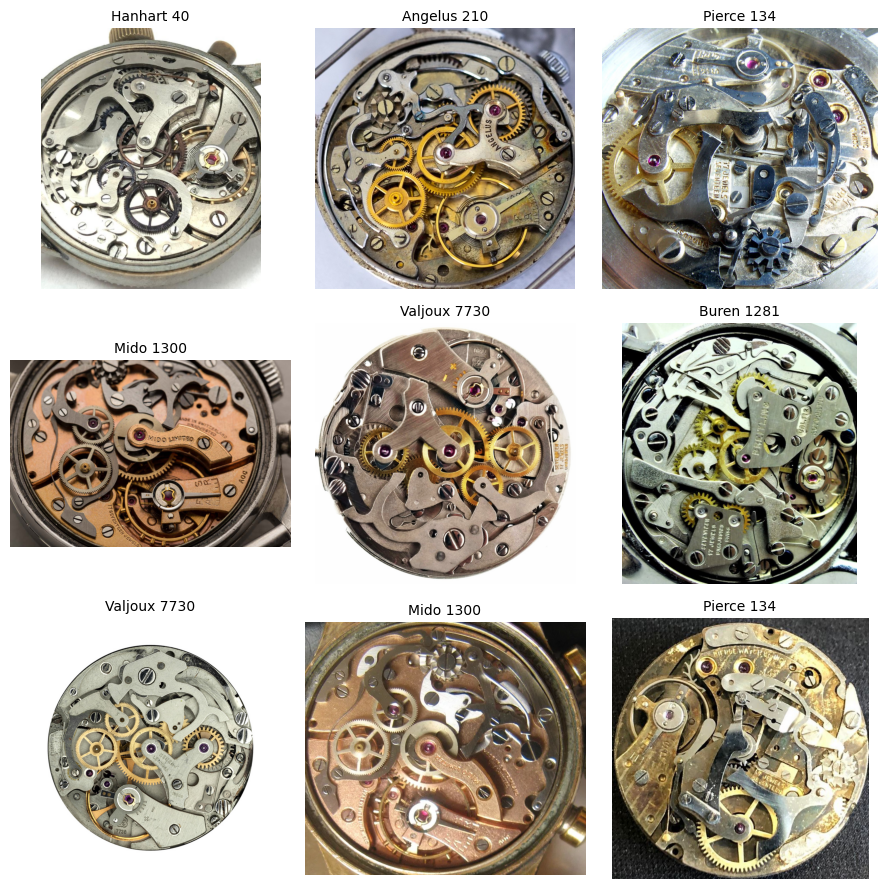

In [62]:
plot_original_sample_images('./movement_database', save_path='./img/sample_images.png')

In [63]:
def get_data_loaders(config: TrainingConfiguration) -> Tuple[DataLoader, DataLoader, List[str]]:
    """
    Prepares the data loaders for training and validation datasets.
    
    Args:
        config (TrainingConfiguration): The configuration settings for the data loaders.

    Returns:
        Tuple[DataLoader, DataLoader, List[str]]: Data loaders for training and validation, and the list of class names.
    """
    data_transforms = transforms.Compose([
        transforms.Resize((256,256), interpolation=transforms.InterpolationMode.BICUBIC),
        #transforms.CenterCrop(224),
        transforms.RandomRotation(degrees=45),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
    ])

    dataset = ImageFolder(config.data_dir, transform=data_transforms)
    class_names = dataset.classes

    train_size = int(config.train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, num_workers=config.num_workers)

    return train_loader, val_loader, class_names



In [64]:
train_loader, val_loader, class_names = get_data_loaders(TrainingConfiguration)

In [65]:
def plot_original_sample_images(data_dir, num_images=9, save_path=None):
    """
    Plots a sample of original images from the dataset in a 3x3 grid and optionally saves the plot.

    Args:
        data_dir (str): Path to the root directory of the dataset.
        num_images (int, optional): Number of images to display. Defaults to 9.
        save_path (str, optional): Path to save the plot as a PNG file. If None, the plot is not saved. Defaults to None.
    """
    # Get all class folders
    class_folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        # Randomly select a class folder
        class_folder = random.choice(class_folders)
        class_path = os.path.join(data_dir, class_folder)
        
        # Randomly select an image from the class folder
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_file = random.choice(image_files)
        image_path = os.path.join(class_path, image_file)
        
        # Open and display the image
        with Image.open(image_path) as img:
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(class_folder, fontsize=10)

    plt.tight_layout()

    # Save the plot if a save path is provided
    if save_path:
        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

Plot saved to ./img/augmented_sample_images.png


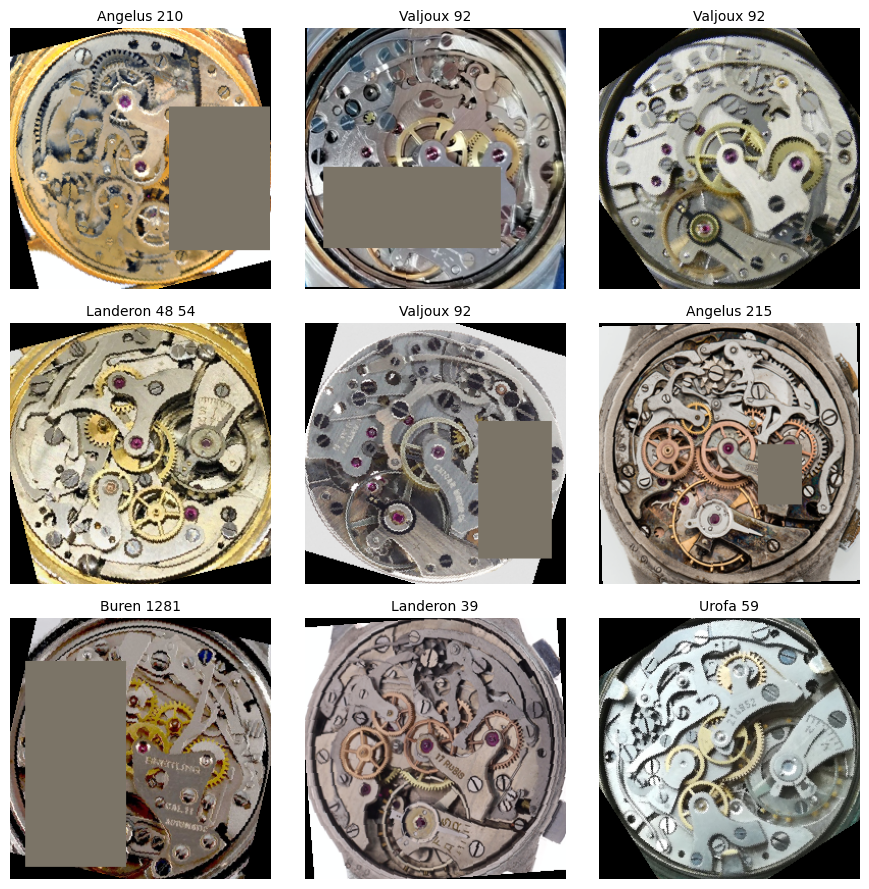

In [66]:
plot_sample_images(train_loader, class_names, save_path='./img/augmented_sample_images.png')

In [67]:

def setup_device(config: TrainingConfiguration) -> torch.device:
    """
    Sets up the device for training.

    Args:
        config (TrainingConfiguration): The configuration settings.

    Returns:
        torch.device: The device to be used for training (CPU or GPU).
    """
    if torch.cuda.is_available():
        logger.info("CUDA is available!")
        if config.multi_gpu:
            device = torch.device("cuda")
            logger.info(f"Using {torch.cuda.device_count()} GPUs for training.")
        else:
            device = torch.device("cuda:0")
            logger.info("Using single GPU for training.")
    else:
        logger.info("CUDA is not available. Using CPU.")
        device = torch.device("cpu")
    return device

def build_model(num_classes: int, device: torch.device, multi_gpu: bool) -> nn.Module:
    """
    Builds the ResNet152 model with the specified number of output classes.
    
    Args:
        num_classes (int): The number of output classes.
        device (torch.device): The device to use for the model.
        multi_gpu (bool): Flag to use multiple GPUs.
    
    Returns:
        nn.Module: The constructed model.
    """
    model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(model.fc.in_features, num_classes)
    )
    model = model.to(device)
    if multi_gpu and torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    return model


In [68]:

def evaluate_model(model: nn.Module, data_loader: DataLoader, criterion: nn.Module, device: torch.device) -> Tuple[float, float]:
    """
    Evaluates the model on the provided data loader.
    
    Args:
        model (nn.Module): The model to evaluate.
        data_loader (DataLoader): Data loader for evaluation.
        criterion (nn.Module): Loss function.
        device (torch.device): The device to use for evaluation.
    
    Returns:
        Tuple[float, float]: The average loss and accuracy.
    """
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


In [77]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                criterion: nn.Module, optimizer: torch.optim.Optimizer, scheduler: ReduceLROnPlateau, 
                device: torch.device, config: TrainingConfiguration) -> Tuple[nn.Module, Dict[str, List[float]]]:
    """
    Trains the model using the provided data loaders and configuration.
    
    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): Data loader for training data.
        val_loader (DataLoader): Data loader for validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        scheduler (ReduceLROnPlateau): Learning rate scheduler.
        device (torch.device): The device to use for training.
        config (TrainingConfiguration): The training configuration.
    
    Returns:
        Tuple[nn.Module, Dict[str, List[float]]]: The trained model and a dictionary of training metrics.
    """
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    scaler = GradScaler(enabled=config.use_amp)

    metrics = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(config.max_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(enabled=config.use_amp):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)

        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)

        logger.info(f'Epoch [{epoch+1}/{config.max_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                    f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= config.patience:
                logger.info("Early stopping triggered!")
                break

        scheduler.step(val_loss)

    model.load_state_dict(torch.load('best_model.pth'))
    return model, metrics

In [96]:
class ProgressiveUnfreezingResNet152(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
        self.freeze_all_layers()

    def freeze_all_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def unfreeze_layer(self, layer_name: str):
        if hasattr(self.model, layer_name):
            for param in getattr(self.model, layer_name).parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.model(x)

def train_with_progressive_unfreezing(
    model: ProgressiveUnfreezingResNet152,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    config: TrainingConfiguration
) -> Tuple[nn.Module, Dict[str, List[float]]]:
    
    stages = [
        ("fc", config.learning_rate),
        ("layer4", config.learning_rate * 0.1),
        ("layer3", config.learning_rate * 0.05),
        ("layer2", config.learning_rate * 0.025),
        ("layer1", config.learning_rate * 0.01)
    ]

    metrics = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    scaler = GradScaler(enabled=config.use_amp)
    
    for stage, lr in stages:
        print(f"Unfreezing {stage} with learning rate {lr}")
        model.unfreeze_layer(stage)
        
        optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=config.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
        
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        
        for epoch in range(config.max_epochs // len(stages)):
            model.train()
            running_loss, correct, total = 0.0, 0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with autocast(enabled=config.use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

            train_loss = running_loss / len(train_loader)
            train_acc = 100 * correct / total
            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)

            val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
            metrics['val_loss'].append(val_loss)
            metrics['val_acc'].append(val_acc)

            print(f'Stage: {stage}, Epoch [{epoch+1}/{config.max_epochs // len(stages)}], '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                torch.save(model.state_dict(), f'best_model_{stage}.pth')
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= config.patience:
                    print(f"Early stopping for stage {stage}")
                    break

            scheduler.step(val_loss)

    # Load the best model from the last stage
    model.load_state_dict(torch.load(f'best_model_{stages[-1][0]}.pth'))
    return model, metrics

In [70]:
def generate_classification_report(model: nn.Module, data_loader: DataLoader, class_names: List[str], device: torch.device, save_path: str = None) -> None:
    """
    Generates a classification report and confusion matrix heatmap for the model.
    
    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): Data loader for evaluation.
        class_names (List[str]): List of class names.
        device (torch.device): The device to use for evaluation.
        save_path (str, optional): Path to save the confusion matrix heatmap. If None, the plot is not saved. Defaults to None.
    """
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate and log classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    logger.info("\nClassification Report:\n" + report)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Confusion matrix heatmap saved to {save_path}")
    
    plt.show()

In [98]:
#device = setup_device(training_config)
#model = build_model(len(class_names), device, training_config.multi_gpu)

#criterion = nn.CrossEntropyLoss()
#optimizer = AdamW(model.parameters(), lr=training_config.learning_rate, weight_decay=training_config.weight_decay)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

#model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, training_config)

# Finetuning version
# Usage
device = setup_device(training_config)
model = ProgressiveUnfreezingResNet152(len(class_names)).to(device)

#if training_config.multi_gpu and torch.cuda.device_count() > 1:
#    model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
model, metrics = train_with_progressive_unfreezing(model, train_loader, val_loader, criterion, device, training_config)

INFO:__main__:CUDA is available!
INFO:__main__:Using 2 GPUs for training.


Unfreezing fc with learning rate 0.001
Stage: fc, Epoch [1/30], Train Loss: 2.8873, Train Acc: 13.46%, Val Loss: 2.7138, Val Acc: 16.67%
Stage: fc, Epoch [2/30], Train Loss: 2.6209, Train Acc: 19.58%, Val Loss: 2.5258, Val Acc: 18.06%
Stage: fc, Epoch [3/30], Train Loss: 2.3859, Train Acc: 24.83%, Val Loss: 2.3771, Val Acc: 24.31%
Stage: fc, Epoch [4/30], Train Loss: 2.2039, Train Acc: 34.97%, Val Loss: 2.1943, Val Acc: 31.94%
Stage: fc, Epoch [5/30], Train Loss: 2.1650, Train Acc: 35.84%, Val Loss: 2.0633, Val Acc: 43.75%
Stage: fc, Epoch [6/30], Train Loss: 1.9865, Train Acc: 41.96%, Val Loss: 2.0747, Val Acc: 40.97%
Stage: fc, Epoch [7/30], Train Loss: 1.9212, Train Acc: 44.23%, Val Loss: 2.0038, Val Acc: 44.44%
Stage: fc, Epoch [8/30], Train Loss: 1.7865, Train Acc: 49.13%, Val Loss: 1.9160, Val Acc: 39.58%
Stage: fc, Epoch [9/30], Train Loss: 1.7276, Train Acc: 51.92%, Val Loss: 1.7963, Val Acc: 47.92%
Stage: fc, Epoch [10/30], Train Loss: 1.6545, Train Acc: 52.10%, Val Loss: 1.61

In [99]:
def plot_training_history(train_loss, val_loss, train_acc, val_acc, save_path=None):
    """
    Plots the training and validation loss and accuracy curves.

    Args:
        train_loss (list): List of training loss values for each epoch.
        val_loss (list): List of validation loss values for each epoch.
        train_acc (list): List of training accuracy values for each epoch.
        val_acc (list): List of validation accuracy values for each epoch.
        save_path (str, optional): Path to save the plot. If None, the plot is not saved. Defaults to None.
    """
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training history plot saved to {save_path}")

    plt.show()

Training history plot saved to ./img/training_history.png


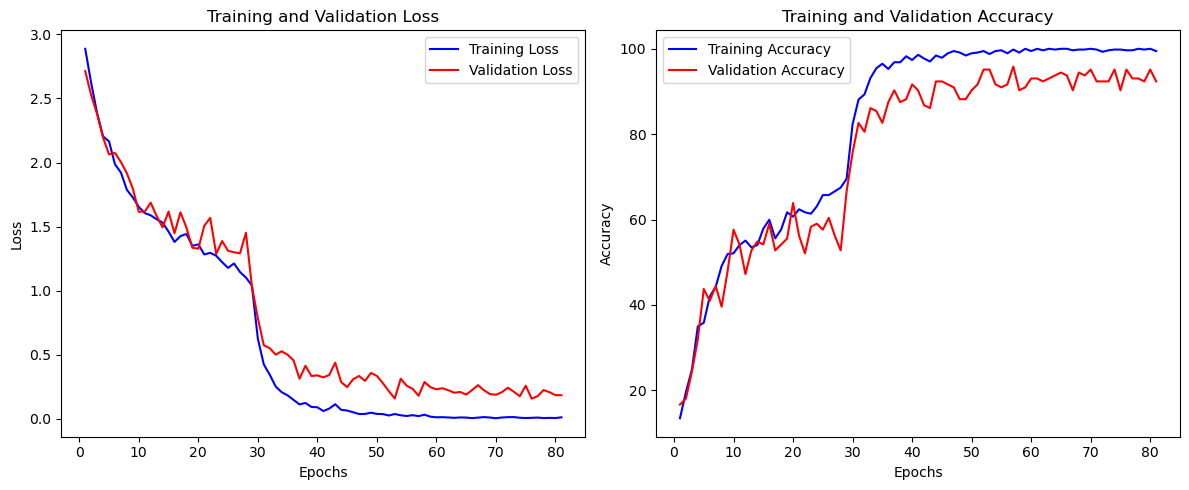

In [100]:
plot_training_history(metrics['train_loss'], metrics['val_loss'], 
                          metrics['train_acc'], metrics['val_acc'], 
                          save_path='./img/training_history.png')


INFO:__main__:
Classification Report:
                precision    recall  f1-score   support

   Angelus 210       0.71      1.00      0.83         5
   Angelus 215       1.00      0.83      0.91         6
    Buren 1281       1.00      0.88      0.93         8
  Excelsior 4X       0.92      1.00      0.96        11
    Hanhart 40       1.00      1.00      1.00         8
  Landeron 148       0.88      0.88      0.88         8
  Landeron 248       1.00      0.83      0.91         6
   Landeron 39       1.00      1.00      1.00         3
Landeron 48 54       0.91      1.00      0.95        10
     Mido 1300       0.90      1.00      0.95         9
    Pierce 134       1.00      1.00      1.00         9
      Urofa 59       1.00      1.00      1.00        10
    Valjoux 22       0.95      0.91      0.93        23
  Valjoux 7730       1.00      0.80      0.89         5
    Valjoux 92       0.80      0.89      0.84         9
     Venus 170       1.00      0.89      0.94         9
     Venu

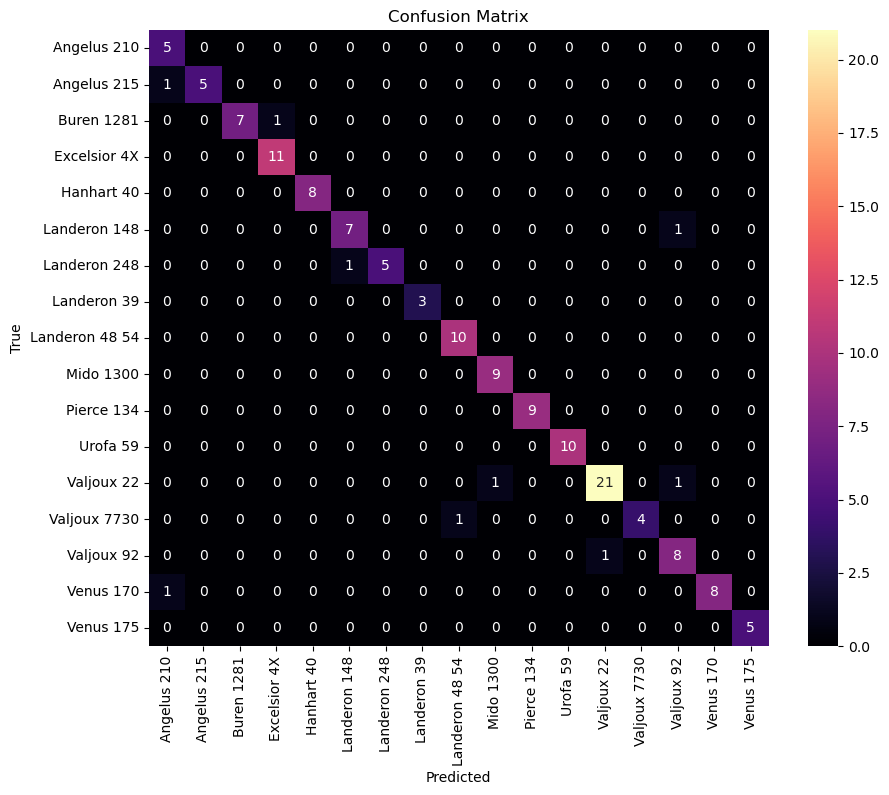

In [101]:
generate_classification_report(model, val_loader, class_names, device, save_path='./img/confusion_matrix.png')

In [102]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curve(model, data_loader, class_names, device, save_path=None):
    """
    Plots the ROC curve for each class and calculates the AUC.

    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): Data loader for evaluation.
        class_names (List[str]): List of class names.
        device (torch.device): The device to use for evaluation.
        save_path (str, optional): Path to save the plot. If None, the plot is not saved.

    Returns:
        dict: A dictionary containing AUC scores for each class.
    """
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_true.extend(labels.numpy())
            y_score.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = len(class_names)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ROC curve plot saved to {save_path}")

    plt.show()

    return roc_auc

# Usage:
# auc_scores = plot_roc_curve(model, val_loader, class_names, device, save_path='./img/roc_curve.png')

ROC curve plot saved to ./img/roc_curve.png


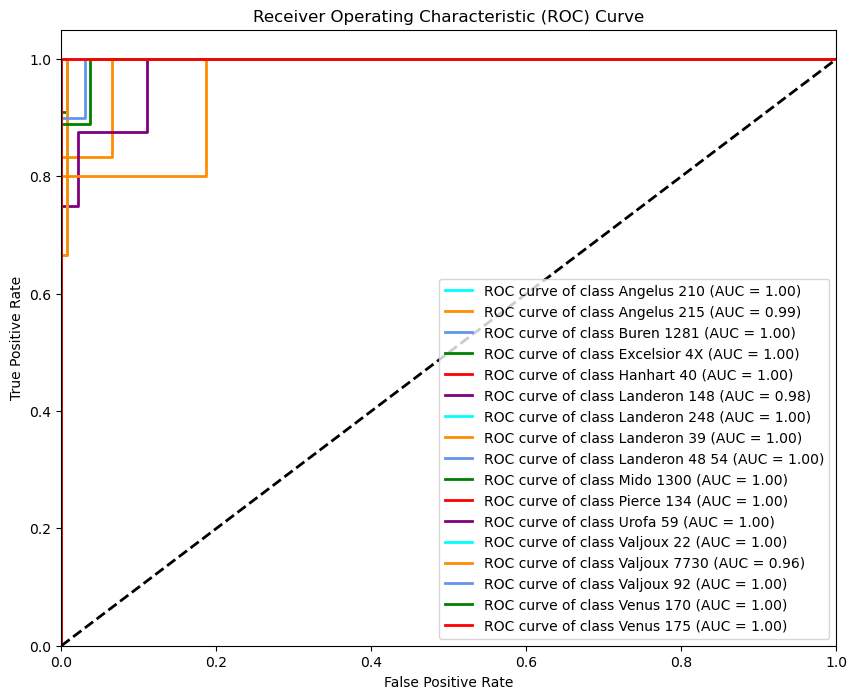

In [103]:
auc_scores = plot_roc_curve(model, val_loader, class_names, device, save_path='./img/roc_curve.png')

In [104]:
import random

def analyze_prediction_errors(model, data_loader, class_names, device, num_samples=10, save_path=None):
    """
    Analyzes and visualizes prediction errors.

    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): Data loader for evaluation.
        class_names (List[str]): List of class names.
        device (torch.device): The device to use for evaluation.
        num_samples (int): Number of misclassified samples to display.
        save_path (str, optional): Path to save the plot. If None, the plot is not saved.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((inputs[i], labels[i], preds[i]))

    num_samples = min(num_samples, len(misclassified))
    samples = random.sample(misclassified, num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, (img, true_label, pred_label) in enumerate(samples):
        img = img.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        axes[i].axis('off')

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Prediction errors plot saved to {save_path}")

    plt.show()

# Usage:
# analyze_prediction_errors(model, val_loader, class_names, device, save_path='./img/prediction_errors.png')

Prediction errors plot saved to ./img/prediction_errors.png


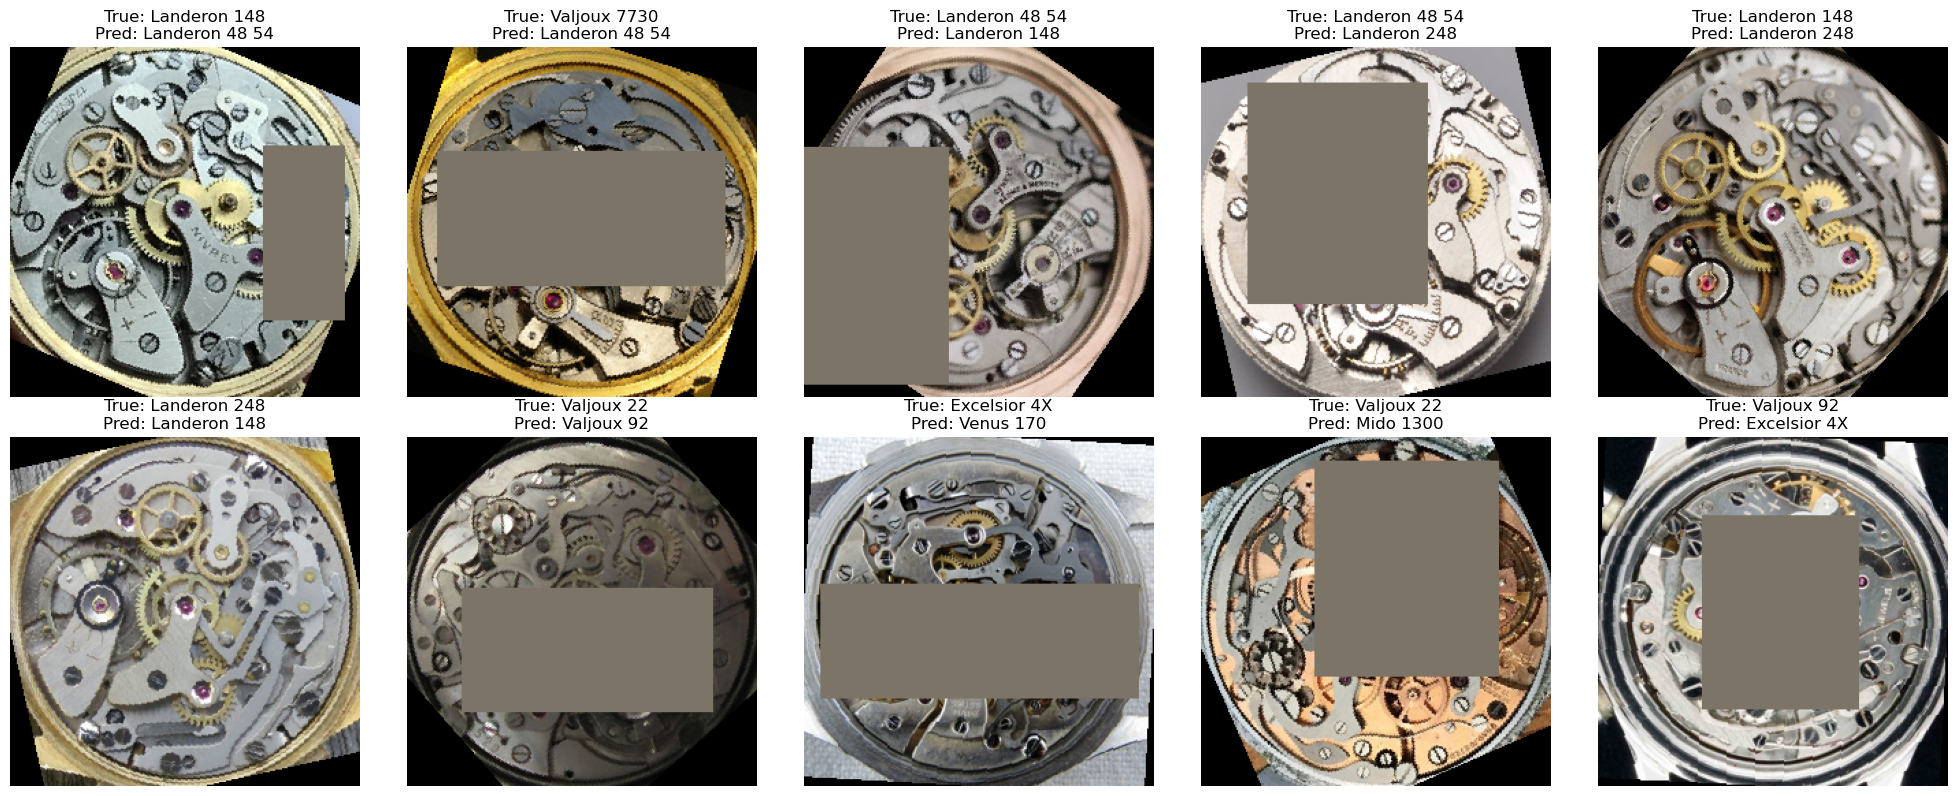

In [105]:
analyze_prediction_errors(model, val_loader, class_names, device, save_path='./img/prediction_errors.png')

In [108]:
def analyze_model_confidence(model, data_loader, class_names, device, save_path=None):
    """
    Analyzes the model's confidence in its predictions.

    Args:
        model (nn.Module): The trained model.
        data_loader (DataLoader): Data loader for evaluation.
        class_names (List[str]): List of class names.
        device (torch.device): The device to use for evaluation.
        save_path (str, optional): Path to save the plot. If None, the plot is not saved.
    """
    model.eval()
    confidences = {class_name: [] for class_name in class_names}
    correct_confidences = []
    incorrect_confidences = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, preds = torch.max(probabilities, 1)
            
            for i in range(inputs.size(0)):
                confidences[class_names[labels[i]]].append(confidence[i].item())
                if preds[i] == labels[i]:
                    correct_confidences.append(confidence[i].item())
                else:
                    incorrect_confidences.append(confidence[i].item())

    # Plot confidence distribution for each class
    plt.figure(figsize=(12, 6))
    for class_name, conf in confidences.items():
        sns.kdeplot(conf, shade=True, label=class_name)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Each Class')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_class_confidence.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Plot confidence distribution for correct vs incorrect predictions
    plt.figure(figsize=(12, 6))
    sns.kdeplot(correct_confidences, shade=True, label='Correct Predictions')
    sns.kdeplot(incorrect_confidences, shade=True, label='Incorrect Predictions')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_correct_vs_incorrect.png'), dpi=300, bbox_inches='tight')
    plt.show()

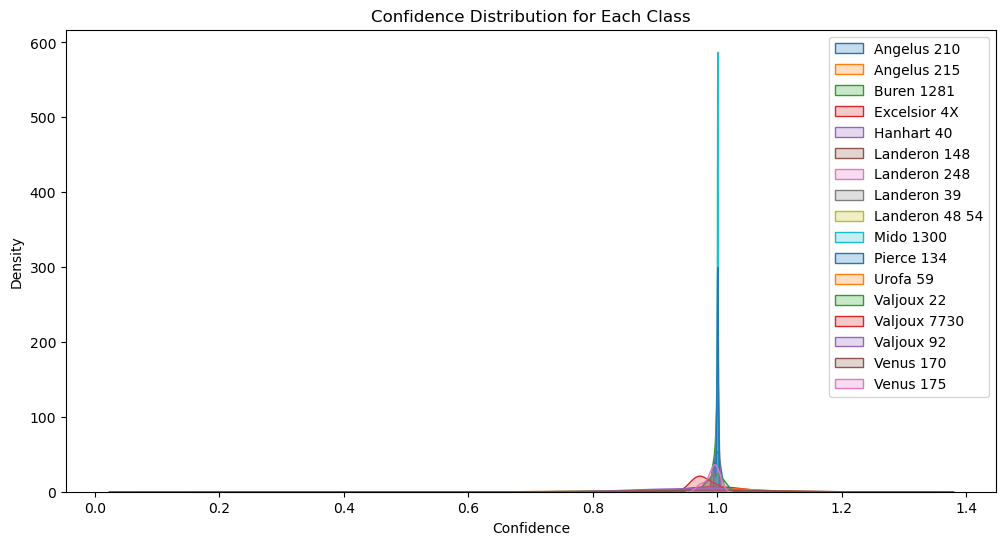

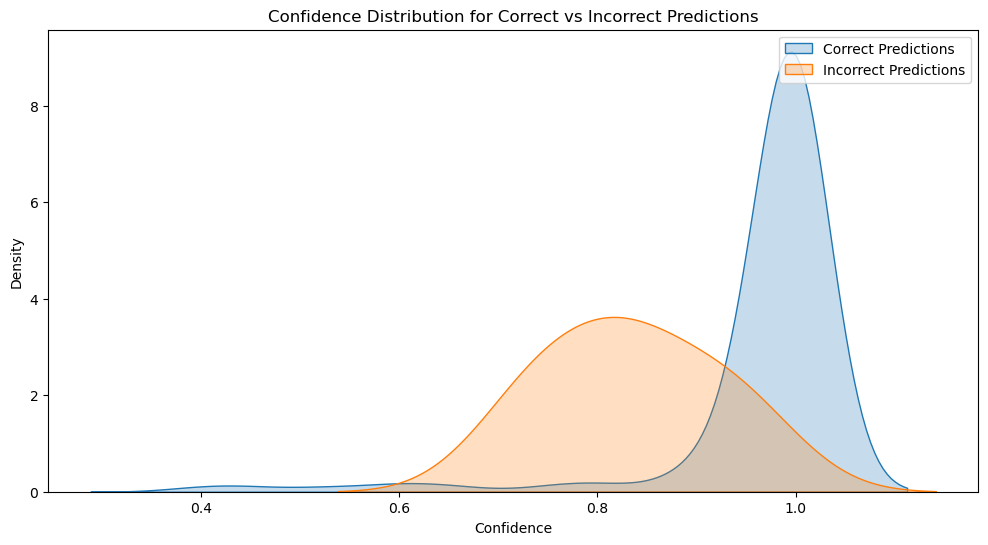

In [107]:
analyze_model_confidence(model, val_loader, class_names, device, save_path='./img/model_confidence.png')